In [ ]:
from scipy import integrate
from scipy.linalg import expm
from pylab import *
import numpy as np
import scipy as sp
from scipy.sparse.linalg import eigs

# Conventions:
# B[i,a,b] has axes (physical, left virtual, right virtual),
# s[i] are schmidt values between sites (i-1, i),
# H_bond[i] is the bond hamiltonian between (i,i+1) with (only physical)

In [ ]:
def init_fm_mps(L):
    """ Returns FM Ising MPS"""
    d = 2
    B = []
    s = []
    for i in range(L):
        B.append(np.zeros([2, 1, 1]))
        B[-1][0, 0, 0] = 1
        s.append(np.ones([1]))
    s.append(np.ones([1]))
    return B, s


def init_ising_U_bond(g, J, L, delta_tau):
    """ Returns bond hamiltonian and bond time-evolution"""
    sx = np.array([[0., 1.], [1., 0.]])
    sz = np.array([[1., 0.], [0., -1.]])
    d = 2

    U_bond = []
    H_bond = []
    for i in range(L):
        H = -J * np.kron(sz, sz) + g * np.kron(sx, np.eye(2))
        H_bond.append(np.reshape(H, (d, d, d, d)))
        U_bond.append(np.reshape(expm(-delta_tau * H), (d, d, d, d)))

    return U_bond, H_bond


def bond_expectation(B, s, O_list):
    " Expectation value for a bond operator "
    E = []
    L = len(B)
    for i_bond in range(L):
        BB = np.tensordot(B[i_bond], B[np.mod(i_bond + 1, L)], axes=(2, 1))
        sBB = np.tensordot(np.diag(s[np.mod(i_bond, L)]), BB, axes=(1, 1))
        C = np.tensordot(sBB, O_list[i_bond], axes=([1, 2], [2, 3]))
        sBB = np.conj(sBB)
        E.append( np.squeeze(np.tensordot(sBB, C, axes=([0, 3, 1, 2], [0, 1, 2, 3]))).item())
    return E


def site_expectation(B, s, O_list):
    " Expectation value for a site operator "
    E = []
    L = len(B)
    for isite in range(0, L):
        sB = np.tensordot(np.diag(s[np.mod(isite, L)]), B[isite], axes=(1, 1))
        C = np.tensordot(sB, O_list[isite], axes=(1, 0))
        sB = sB.conj()
        E.append(np.squeeze(np.tensordot(sB, C, axes=([0, 1, 2], [0, 2, 1]))).item())
    return E


def entanglement_entropy(s):
    " Returns the half chain entanglement entropy "
    S = []
    for i_bond in range(2):
        x = s[i_bond][s[i_bond] > 10**(-20)]**2
        S.append(-np.inner(np.log(x), x))
    return S


def correlation_length(B):
    " Constructs the mixed transfermatrix and returns correlation length"
    chi = B[0].shape[1]
    L = len(B)

    T = np.tensordot(B[0], np.conj(B[0]), axes=(0, 0))  # a b a' b'
    T = T.transpose(0, 2, 1, 3)  # a a' b b'
    for i in range(1, L):
        T = np.tensordot(T, B[i], axes=(2, 1))  # a a' b' i b
        T = np.tensordot(T, np.conj(B[i]), axes=([2, 3], [1, 0]))  # a a' b b'
    T = np.reshape(T, (chi**2, chi**2))

    # Obtain the 2nd largest eigenvalue
    eta = eigs(T, k=2, which='LM', return_eigenvectors=False, ncv=20)
    return -L / np.log(np.min(np.abs(eta)))


def sweep(B, s, U_bond, chi):
    """ Perform the imaginary time evolution of the MPS """
    L = len(B)
    d = B[0].shape[0]
    for k in [0, 1]:
        for i_bond in range(k, L, 2):
            ia = i_bond
            ib = np.mod(i_bond + 1, L)
            ic = np.mod(i_bond + 2, L)
            chia = B[ia].shape[1]
            chic = B[ib].shape[2]

            # Construct theta matrix and time evolution #
            theta = np.tensordot(B[ia], B[ib], axes=(2, 1))  # i a j b
            theta = np.tensordot(U_bond[i_bond], theta, axes=([2, 3], [0, 2]))  # ip jp a b
            theta = np.tensordot(np.diag(s[ia]), theta, axes=([1, 2]))  # a ip jp b
            theta = np.reshape(np.transpose(theta, (1, 0, 2, 3)), (d*chia, d*chic))  # ip a jp b

            # Schmidt deomposition #
            X, Y, Z = sp.linalg.svd(theta,full_matrices=0,lapack_driver='gesvd')
            chi2 = np.min([np.sum(Y > 10.**(-10)), chi])

            piv = np.zeros(len(Y), bool)
            piv[(np.argsort(Y)[::-1])[:chi2]] = True

            Y = Y[piv]
            invsq = np.sqrt(sum(Y**2))
            X = X[:, piv]
            Z = Z[piv, :]

            # Obtain the new values for B and s #
            s[ib] = Y / invsq
            X = np.reshape(X, (d, chia, chi2))
            X = np.transpose(
                np.tensordot(np.diag(s[ia]**(-1)), X, axes=(1, 1)), (1, 0, 2))
            B[ia] = np.tensordot(X, np.diag(s[ib]), axes=(2, 0))
            B[ib] = np.transpose(np.reshape(Z, (chi2, d, chic)), (1, 0, 2))


In [ ]:
def itebd_ising_gs(J, g, T, delta_tau_list, chi):
    B, s = init_fm_mps(2)
    sz = np.array([[1., 0.], [0., -1.]])

    for delta_tau in delta_tau_list:
        U_bond, H_bond = init_ising_U_bond(g, J, 2, delta_tau)

        for i in range(int(T / delta_tau)):
            sweep(B, s, U_bond, chi)

        E = np.mean(bond_expectation(B, s, H_bond))
        m = np.mean(site_expectation(B, s, [sz, sz]))
        S = np.mean(entanglement_entropy(s))
        xi = np.mean(correlation_length(B))

        print("E=%.6f" % E,
              "m=%.6f" % m,
              "S=%.6f" % S,
              "xi=%.6f" % xi,
              "(iTEBD, delta_tau =", delta_tau, ")")
    return E, m, S, xi, B, s

def itebd_ising_quench(B ,s, J, g, T, delta_t,chi):
    U_bond, H_bond = init_ising_U_bond(g, J, 2, 1j*delta_t)
    t_list = []
    m_list = []
    S_list = []

    for i in range(1,int(T / delta_t)+1):
            sweep(B, s, U_bond, chi)
            t_list.append(i*delta_t)
            m_list.append(np.mean(site_expectation(B, s, [sz, sz])))
            S_list.append(np.mean(entanglement_entropy(s)))


    return t_list,m_list,S_list

In [ ]:
# Find the ground state using imaginary time evolution

J = 1
g = 0.1
chi = 10
T = 10.
delta_tau_list = [0.1,0.01,0.001]

E, m, S, xi, B, s = itebd_ising_gs(J, g, T, delta_tau_list, chi)

f = lambda k, g: -2*np.sqrt(1 + g**2 - 2*g*np.cos(k)) / np.pi / 2.
E0_exact = integrate.quad(f, 0, np.pi, args=(g,))[0]
print("\n|E_itebd - E_exact| =", np.abs(E - E0_exact))

E=-1.002477 m=0.998732 S=0.000009 xi=0.207819 (iTEBD, delta_tau = 0.1 )
E=-1.002501 m=0.998744 S=0.000006 xi=0.207794 (iTEBD, delta_tau = 0.01 )
E=-1.002502 m=0.998744 S=0.000006 xi=0.207794 (iTEBD, delta_tau = 0.001 )

|E_itebd - E_exact| = 6.187543810654006e-10


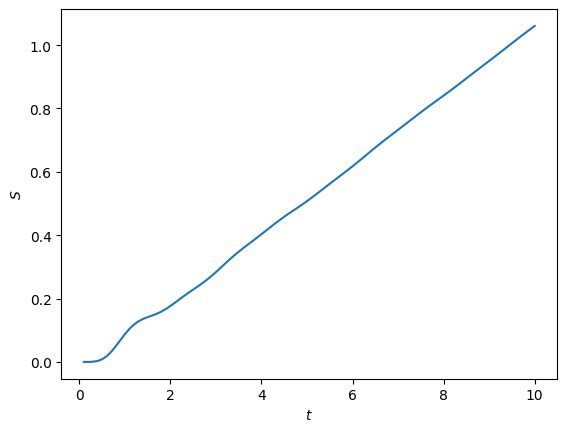

In [ ]:
# Quench dynamics from real time evolution

J = 1.0
g = 0.5
chi = 50
T = 10.
delta_t = 0.1

B, s = init_fm_mps(2)
sz = np.array([[1., 0.], [0., -1.]])

t_list,m_list,S_list = itebd_ising_quench(B, s, J, g, T, delta_t,chi)
plot(t_list,S_list)
xlabel('$t$');
ylabel('$S$');